# 使用tensorflow实现CNN

In [12]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
%matplotlib inline
np.random.seed(1)

from cnn_utils import  load_dataset

y=0


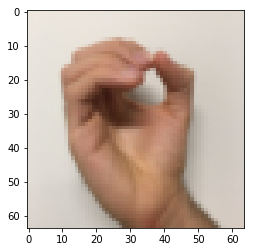

In [13]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

index=1
plt.imshow(X_train_orig[index])
print("y={}".format(np.squeeze(Y_train_orig[:,index])))

- one-hot编码用的是 `np.eye(C)[Y.reshape(-1)].T`代码，原理是numpy 切片; 非常经典的用法


In [14]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.

Y_train=np.eye(6)[Y_train_orig.reshape(-1)].T
print(Y_train.shape)
Y_test=np.eye(6)[Y_test_orig.reshape(-1)].T
print(Y_test.shape)

(6, 1080)
(6, 120)


In [15]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))


number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (6, 1080)
X_test shape: (120, 64, 64, 3)
Y_test shape: (6, 120)


# 1 place holder

- Y [None,n_y]

In [16]:
def create_placeholders(n_H0,n_W0,n_C0,n_y):
    """
    

    Parameters
    ----------
    n_H0: 
    n_W0:
    n_C0:
    n_y: 

    Returns
    -------
    X: (None,n_H0,n_W0,n_C0)
    Y: (None,n_y)
     
    """
    X=tf.placeholder(tf.float32,shape=(None,n_H0,n_W0,n_C0))
    Y=tf.placeholder(tf.float32,shape=(None,n_y))
    return X,Y
    

In [17]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder_2:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_3:0", shape=(?, 6), dtype=float32)


## 2 初始化参数

- eval方法可以用来观察值

In [18]:
def initialize_parameters():
    """
    W1 [4，4，3,8]
    W2 [2,2,8,16]

    Parameters
    ----------
     : 

    Returns
    -------
    Parameters : dict W1 W2
     
    """    
    tf.set_random_seed(1)
    
    W1=tf.get_variable(name='W1',shape=[4,4,3,8],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2=tf.get_variable(name='W2',shape=[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed=0))    
    parameters={"W1":W1,"W2":W2}
    return parameters

In [19]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters=initialize_parameters()
    init=tf.global_variables_initializer()
    sess.run(init)
    print("W1 = " + str(parameters['W1'].eval()[1,1,1]))
    print("W2 = " + str(parameters['W2'].eval()[1,1,1]))
    


W1 = [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


## 正向传播
- 【bug1】strides=(1,4,4,1)

```
~/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py in conv2d(input, filter, strides, padding, use_cudnn_on_gpu, data_format, dilations, name)
    936       raise TypeError(
    937           "Expected list for 'strides' argument to "
--> 938           "'conv2d' Op, not %r." % strides)
    939     strides = [_execute.make_int(_i, "strides") for _i in strides]
    940     padding = _execute.make_str(padding, "padding")

TypeError: Expected list for 'strides' argument to 'conv2d' Op, not 1.

```

- 【bug2】要用max_pool 而不是pool

```
<ipython-input-111-07ee245ebd1a> in forwar_propagation(X, parameters)
     24     Z2=tf.nn.conv2d(input=P1,filter=W2,strides=(1,4,4,1),padding='SAME')
     25     A2=tf.nn.relu(Z2)
---> 26     P2=tf.nn.pool(input=A2,window_shape=(4,4),strides=(1,4,4,1),pooling_type='MAX',padding='SAME')
     27 
```

- 【bug3】   ` Z3=tf.contrib.layers.fully_connected(P2,num_outputs=6,activation_fn=None)`中
`activation_fn=None`不可缺少


#### 要能够把完整过程推导出来

In [20]:
def forward_propagation(X,parameters):
    """
    正向传播（conv-relu-pool）
    Parameters
    ----------
    X: (m,n_H0,n_W0,n_C0)
    parameters :
        W1 [4，4，3,8]
        W2 [2,2,8,16]
                    
    Returns
    -------
    Z : 
     
    """    
    
    W1=parameters['W1']
    W2=parameters['W2']    
    
    Z1=tf.nn.conv2d(input=X,filter=W1,strides=[1,1,1,1],padding='SAME')
    A1=tf.nn.relu(Z1)
    P1=tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding='SAME')
    
    Z2=tf.nn.conv2d(input=P1,filter=W2,strides=(1,1,1,1),padding='SAME')
    A2=tf.nn.relu(Z2)
    P2=tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=(1,4,4,1),padding='SAME')
    P2= tf.contrib.layers.flatten(P2)
    
    Z3=tf.contrib.layers.fully_connected(P2,num_outputs=6,activation_fn=None)
    return Z3


In [21]:
tf.reset_default_graph()
with tf.Session() as sess:
    np.random.seed(1)
    X,Y=create_placeholders(64,64,3,6)
    parameters=initialize_parameters()
    Z3=forward_propagation(X,parameters)
    init=tf.global_variables_initializer()
    sess.run(init)    
    a=sess.run(Z3,feed_dict={X:np.random.randn(2,64,64,3),Y:np.random.randn(2,6)})
    print("Z3 = " + str(a))

Z3 = [[ 1.4416984  -0.24909666  5.450499   -0.2618962  -0.20669907  1.3654671 ]
 [ 1.4070846  -0.02573211  5.08928    -0.48669922 -0.40940708  1.2624859 ]]


## 3 compute cost

- labels shape= [batch_size, num_classes]


In [22]:
def compute_cost(Z3,Y):
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Z3,labels=Y))
    return cost
    


In [23]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    print("Z3=",Z3)
    print("Y=",Y)
    cost = compute_cost(Z3, Y)
    
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))    
    

Z3= Tensor("fully_connected/BiasAdd:0", shape=(?, 6), dtype=float32)
Y= Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)
cost = 4.6648693


## 4 Model

- 【bug】<span style="color:red;font-weight:bold"> IndexError: index 858 is out of bounds for axis 0 with size 6</span>
    - 原因： 输入数据维度不对，要进行维度检查

```
<ipython-input-80-3ede693b7bef> in model(X_train, Y_train, X_test, Y_test, learning_rate, num_epoches, minibatch_size, print_cost)
     26             num_minibatches=int(m/minibatch_size)
     27             seed+=1
---> 28             minibatches=random_mini_batches(X_train,Y_train,minibatch_size,seed)
     29 
     30             for minibatch in minibatches:

~/python-workspace/deep-learning-coursera-full/Convolutional Neural Networks/week1/cnn_utils.py in random_mini_batches(X, Y, mini_batch_size, seed)
     44     permutation = list(np.random.permutation(m))
     45     shuffled_X = X[permutation,:,:,:]
---> 46     shuffled_Y = Y[permutation,:]
     47 
     48     # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.

IndexError: index 858 is out of bounds for axis 0 with size 6

```


- [bug] <span style="color:red;font-weight:bold"> cost没有下降</span>
    - 检查原因：之前遇到过问题：计算损失函数时行列颠倒了
    - 发现问题：打印损失函数的代码放在了epoch内部，这是有问题的

```
Cost after epoch 0: 0.124256
Cost after epoch 0: 0.235755
Cost after epoch 0: 0.346379
Cost after epoch 0: 0.460018
Cost after epoch 0: 0.572946
Cost after epoch 0: 0.686253
Cost after epoch 0: 0.799503
Cost after epoch 0: 0.911139
Cost after epoch 0: 1.023798
Cost after epoch 0: 1.136514
Cost after epoch 0: 1.248791
Cost after epoch 0: 1.360714
Cost after epoch 0: 1.472453
Cost after epoch 0: 1.584704
```

- [方法] <span style="color:red;font-weight:bold">计算softmax准确率的方法 </span>

```
        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

```

- 学习率对结果影响很大，过大的学习率导致下降非常缓慢，且比较容易陷入瓶颈期

In [28]:
from cnn_utils import random_mini_batches
def model(X_train,Y_train,X_test,Y_test,learning_rate=0.009,num_epoches=100,minibatch_size=64,print_cost=True):    
    """
    CONV2D-->RELU-->MAXPOOl-->CON2D-->RELU-->MAXPOOL-->FLATTEN-->FC
    

    Parameters
    ----------
    X_train : (None, 64,64,3)
    Y_train : (None, n_y=6)
    X_test: (None, 64,64,3)
    Y_test:(None, n_y=6)

    Returns
    -------
     : 
     
    """    
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed=3
    (m,n_H0,n_W0,n_C0)=X_train.shape
    n_y=Y_train.shape[1]
    costs=[]

    X,Y=create_placeholders(n_H0, n_W0, n_C0, n_y)

    parameters=initialize_parameters()

    Z3=forward_propagation(X, parameters)

    cost=compute_cost(Z3,Y)

    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    init=tf.global_variables_initializer()

    with  tf.Session() as sess:
        sess.run(init)    
        for epoch in range(num_epoches):

            minibatch_cost=0.
            num_minibatches=int(m/minibatch_size)
            seed+=1            
            minibatches=random_mini_batches(X_train,Y_train,minibatch_size,seed)

            for minibatch in minibatches:
                (minibatch_X,minibatch_Y)=minibatch
                _,temp_cost=sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                minibatch_cost+=temp_cost/num_minibatches



            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)

        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters            
    

- [总结] 当梯度下降学习率过大时，会出现较大的抖动

Cost after epoch 0: 1.921332
Cost after epoch 5: 1.904156
Cost after epoch 10: 1.904309
Cost after epoch 15: 1.904477
Cost after epoch 20: 1.901876
Cost after epoch 25: 1.784078
Cost after epoch 30: 1.681051
Cost after epoch 35: 1.618206
Cost after epoch 40: 1.597971
Cost after epoch 45: 1.566707
Cost after epoch 50: 1.554487
Cost after epoch 55: 1.502187
Cost after epoch 60: 1.461035
Cost after epoch 65: 1.304489
Cost after epoch 70: 1.201760
Cost after epoch 75: 1.163242
Cost after epoch 80: 1.102885
Cost after epoch 85: 1.087105
Cost after epoch 90: 1.051911
Cost after epoch 95: 1.018554
Cost after epoch 100: 1.005099
Cost after epoch 105: 0.957182
Cost after epoch 110: 0.964193
Cost after epoch 115: 0.949561
Cost after epoch 120: 0.925645
Cost after epoch 125: 0.898527
Cost after epoch 130: 0.914478
Cost after epoch 135: 0.862254
Cost after epoch 140: 0.849145
Cost after epoch 145: 0.819312
Cost after epoch 150: 0.836543
Cost after epoch 155: 0.801438
Cost after epoch 160: 0.802415

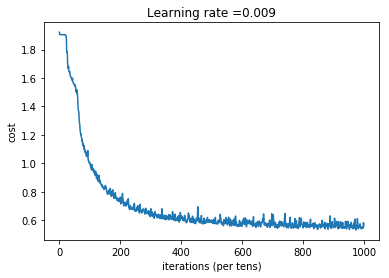

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.8203704
Test Accuracy: 0.675


In [29]:
_, _, parameters = model(X_train, Y_train.T, X_test, Y_test.T,num_epoches=1000)

Cost after epoch 0: 1.971088
Cost after epoch 5: 1.894469
Cost after epoch 10: 1.881239
Cost after epoch 15: 1.854496
Cost after epoch 20: 1.777080
Cost after epoch 25: 1.615358
Cost after epoch 30: 1.404743
Cost after epoch 35: 1.187280
Cost after epoch 40: 1.048417
Cost after epoch 45: 0.915120
Cost after epoch 50: 0.839881
Cost after epoch 55: 0.758703
Cost after epoch 60: 0.701555
Cost after epoch 65: 0.640890
Cost after epoch 70: 0.615407
Cost after epoch 75: 0.581381
Cost after epoch 80: 0.555603
Cost after epoch 85: 0.525676
Cost after epoch 90: 0.492369
Cost after epoch 95: 0.478995


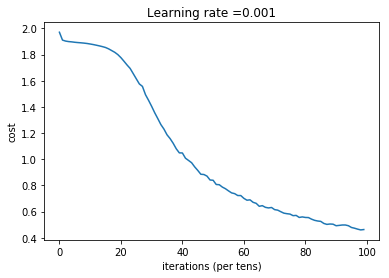

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.84166664
Test Accuracy: 0.775


In [30]:
_, _, parameters = model(X_train, Y_train.T, X_test, Y_test.T,learning_rate=0.001,num_epoches=100)


Cost after epoch 0: 2.012588
Cost after epoch 5: 1.900229
Cost after epoch 10: 1.888745
Cost after epoch 15: 1.879187
Cost after epoch 20: 1.863316
Cost after epoch 25: 1.841501
Cost after epoch 30: 1.798425
Cost after epoch 35: 1.721196
Cost after epoch 40: 1.601986
Cost after epoch 45: 1.466162
Cost after epoch 50: 1.354402
Cost after epoch 55: 1.253490
Cost after epoch 60: 1.174554
Cost after epoch 65: 1.108251
Cost after epoch 70: 1.049195
Cost after epoch 75: 1.001917
Cost after epoch 80: 0.953724
Cost after epoch 85: 0.904982
Cost after epoch 90: 0.863703
Cost after epoch 95: 0.824888
Cost after epoch 100: 0.794920
Cost after epoch 105: 0.765818
Cost after epoch 110: 0.735164
Cost after epoch 115: 0.707815
Cost after epoch 120: 0.697145
Cost after epoch 125: 0.672554
Cost after epoch 130: 0.637609
Cost after epoch 135: 0.615952
Cost after epoch 140: 0.596869
Cost after epoch 145: 0.580574
Cost after epoch 150: 0.565618
Cost after epoch 155: 0.549066
Cost after epoch 160: 0.527261

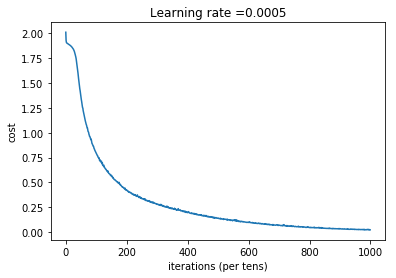

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 1.0
Test Accuracy: 0.8666667


In [32]:
_, _, parameters = model(X_train, Y_train.T, X_test, Y_test.T,learning_rate=0.0005,num_epoches=1000)